In [1]:
from numpy import unravel_index
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
import random 
from copy import deepcopy
random.seed(0)
from numpy.random import Generator, PCG64
from random import sample
import timeit

In [2]:
class ServerIDs(Enum):
    """
    Description: 
        Class storing server names
    """
    msn = 'MSN'
    asn_1 = 'ASN1'
    asn_2 = 'ASN2'

class Groups(Enum):
    """
    Description: 
        Class storing group ids
    """
    Group_1 = 1
    Group_2 = 2
    Group_3 = 3

    
    
class Status(Enum):
    """
    Description: 
        Class storing status - First Come First Serve (FCFS) principle
    """
    handled = -1
    served = 0
    arrived = np.inf
    
class CustomerGroup:
    """
    Description: 
        Class storing all customer group specific information
    """
    def __init__(self,ID,popularity,activity_pattern,distances):
        self.ID = ID
        self.popularity = popularity
        self.weights=popularity/np.sum(popularity)
        self.activity_pattern = activity_pattern
        self.distances = distances
    
    def best_server_options(self):
        """
        Description: 
            Finding server options
        Return:
            list (str) - sorted list of server options from best to worst
        """
        return sorted(self.distances, key=self.distances.get)
     
class Server:
    """ 
    Description: 
        Class representing the servers {MSN, ASN1, ASN2}
    """
    def __init__(self, id_, movies_stored, capacity, movie_sizes):
        self.id = id_
        self.movies_stored = movies_stored
        self.capacity = capacity
        self.movie_sizes = movie_sizes
        
         # Parameter for checking that the capacity limited of the server is not succeeded
        self.capacity_check = capacity
        self.check_capacity_limit()
        
    def check_capacity_limit(self):
        """
        Description: 
            Check capacity limited is not succeeded
        """
        for movie in self.movies_stored:
            self.capacity_check -= self.movie_sizes[movie]
            if self.capacity_check < 0:
                raise Exception('Server Capacity Exceeded')
        
class LoadBalancer:
    """ 
    Description: 
        Superclass storing the servers and all associated information (e.g. such as serving time)
    """
    def __init__(self, movies_stored_msn, movies_stored_asn_1, movies_stored_asn_2,\
                 capacities, serve_times, movie_sizes):
        self.msn = Server(ServerIDs.msn.value, movies_stored_msn, capacities[0], movie_sizes)
        self.asn_1 = Server(ServerIDs.asn_1.value, movies_stored_asn_1, capacities[1], movie_sizes)
        self.asn_2 = Server(ServerIDs.asn_2.value, movies_stored_asn_2, capacities[2], movie_sizes)
        self.serve_times = serve_times
        self.movie_sizes = movie_sizes
        
    def get_serve_time(self, movie: int, group_id: int, server_id: str):
        """
        Description: 
            Return service time based on input arguments
        Args: 
            int - chosen movie
            int - group_id of customer group \in {1,2,3}
            string - server_id of server \in {'MSN', 'ASN1', 'ASN2'}
        Return:
            Int - serve time
        """
        movie_size = self.movie_sizes[movie]
        if movie_size < 900:
            return self.serve_times[900][server_id][group_id]
            
        elif movie_size >= 900 and movie_size < 1100:
            return self.serve_times[1100][server_id][group_id]
            
        elif movie_size >= 1100:
            return self.serve_times[1500][server_id][group_id]
        else:
            raise Exception(f'Movie Size: {movie_size}')
        
class SingleCustomer:
    """ 
    Description: 
        Class representing single customer
    """
    def __init__(self,id_,time,movie_choice,server_address,waiting_time):
        self.id_ = id_
        self.status = Status.arrived.value
        self.time = time
        self.movie_choice = movie_choice
        self.waiting_time = waiting_time
        self.server_address = server_address

In [3]:
class Scenario:
    
    def __init__(self, asn_allocations_1: list, asn_allocations_2: list):
        
        self.capacities = [np.inf, 3500,3500]

        self.movie_sizes = {
            0: 850,
            1: 950,
            2: 1000,
            3: 1200,
            4: 800,
            5: 900,
            6: 1000,
            7: 750,
            8: 700,
            9: 1100
        }

        self.movies_stored_msn = list(range(0, 10))
        self.movies_stored_asn_1 = asn_allocations_1
        self.movies_stored_asn_2 = asn_allocations_2

        # --- Table 2 ---
        # Preferences
        self.popularities = [[2,4,9,8,1,3,5,7,10,6],[6,1,3,4,7,9,2,5,8,10],[4,7,3,6,1,10,2,9,8,5]]

        # --- Table 3 ---
        # Lambdas
        self.activity_patterns = [[0.8,1.2,0.5],[0.9,1.3,0.3],[0.7,1.5,0.4]]

        # --- Table 4 ---
        self.distances_g1 = {ServerIDs.msn.value: 0.5, ServerIDs.asn_1.value: 0.2, ServerIDs.asn_2.value: np.inf}
        self.distances_g2 = {ServerIDs.msn.value: 0.5, ServerIDs.asn_1.value: 0.3, ServerIDs.asn_2.value: 0.4}
        self.distances_g3 = {ServerIDs.msn.value: 0.5, ServerIDs.asn_1.value: np.inf, ServerIDs.asn_2.value: 0.2}

        # --- Table 5 ---
        # [700- 900)
        self.msn_serve_time_900 = {1: 9, 2: 8, 3: 10}
        self.asn_1_serve_time_900 = {1: 3, 2: 4, 3: np.inf}
        self.asn_2_serve_time_900 = {1: np.inf, 2: 5, 3: 4}

        self.serve_times_900 = {
            ServerIDs.msn.value: self.msn_serve_time_900,
            ServerIDs.asn_1.value: self.asn_1_serve_time_900,
            ServerIDs.asn_2.value: self.asn_2_serve_time_900
        }

        # [900- 1100)
        self.msn_serve_time_1100 = {1: 12, 2: 11, 3: 13}
        self.asn_1_serve_time_1100 = {1: 4, 2: 5, 3: np.inf}
        self.asn_2_serve_time_1100 = {1: np.inf, 2: 6, 3: 5}

        self.serve_times_1100 = {
            ServerIDs.msn.value: self.msn_serve_time_1100,
            ServerIDs.asn_1.value: self.asn_1_serve_time_1100,
            ServerIDs.asn_2.value: self.asn_2_serve_time_1100
        }

        # [1100- 1500)
        self.msn_serve_time_1500 = {1: 15, 2: 14, 3: 16}
        self.asn_1_serve_time_1500 = {1: 5, 2: 6, 3: np.inf}
        self.asn_2_serve_time_1500 = {1: np.inf, 2: 7, 3: 6}

        self.serve_times_1500 = {
            ServerIDs.msn.value: self.msn_serve_time_1500,
            ServerIDs.asn_1.value: self.asn_1_serve_time_1500,
            ServerIDs.asn_2.value: self.asn_2_serve_time_1500
        }

        self.serve_times = {
            900: self.serve_times_900,
            1100: self.serve_times_1100,
            1500: self.serve_times_1500
        }

In [4]:
def exponential_rng(lam=1.0, u=None):  
    """ 
    Description:
        Generates exponential random number
    Args:
        float - lam, the rate parameter, the inverse expectation of the distribution
    Return:
        float - Exponential random number with given rate
    """
    if not u:
        return -np.log(np.random.rand()) / lam
    else:
        return -np.log(u) / lam

def homogeneous_poisson_process(lam, T):
    """ 
    Description:
        Simulate arrivals via homogeneous Poisson process
    Args:
        float - lam, the rate parameter, the inverse expectation of the distribution
        int - simulation period
    Return:
        list (float) - Arrival times
    """
    arrival_times=[]
    curr_arrival_time=0
    while True:
        curr_arrival_time += exponential_rng(lam)
        if curr_arrival_time > T:
            break
        else:
            arrival_times.append(curr_arrival_time)
    return arrival_times


def homogeneous_poisson_process_variance_reduction(lam, T, u):
    """ 
    Description:
        Simulate arrivals via homogeneous Poisson process
    Args:
        float - lam, the rate parameter, the inverse expectation of the distribution
        int - simulation period
    Return:
        list (float) - Arrival times
    """
    arrival_times=[]
    curr_arrival_time=0
    counter = -1
    while True:
        counter += 1
        curr_arrival_time += exponential_rng(lam, u[counter])
        if curr_arrival_time > T:
            break
        else:
            arrival_times.append(curr_arrival_time)
    return arrival_times



def adjust_time_and_pick_a_movie(arrival_times: list, delta_T: int, G: CustomerGroup, load_balancer: LoadBalancer)-> list:
    """
    Description:
        Create single customers and assign attributes (e.g. movie, server address)
    Args:
        list (float) - arrival times
        int - delta_T, time offset for arrival times
        class - Customer group
        class - Load balancer
    Return:
        list (class) - List of customers
    """
    output = []
    for arrival_time in arrival_times:
        movie = np.random.choice(np.arange(10, step=1), size=None, replace=True, p=G.weights)
        servers_with_movie = check_movie_availability_on_server(movie,load_balancer)
        best_servers = G.best_server_options()
        serverAddress = assign_server(servers_with_movie,best_servers)
        waiting_time = G.distances[serverAddress]
        output.append(SingleCustomer(G.ID, arrival_time + delta_T+waiting_time,\
                                     movie,serverAddress,waiting_time))
    return output

def assign_server(servers_with_movie,best_servers):
    """
    Description:
        Find server assignment for single customer
    Args:
        list (str) - server names that movie is stored on
        list (str) - sorted list of optimal servers
    Return:
        list (class) - List of customers
    """
    for best in best_servers:
        if best in servers_with_movie:
            if best!=np.inf:
                return best
            else:
                raise Exception('Movie not available for customer!')

def check_movie_availability_on_server(movie: int,load_balancer: LoadBalancer):
    """
    Description:
        Find all servers that the selected movie is stored on
    Args:
        int - selected movie by customer
        class - Load balancer
    Return:
        list (str) - server names that movie is stored on
    """        
    servers_with_movie=[]
    if movie in load_balancer.msn.movies_stored:
        servers_with_movie.append(ServerIDs.msn.value)
    if movie in load_balancer.asn_1.movies_stored:
        servers_with_movie.append(ServerIDs.asn_1.value)
    if movie in load_balancer.asn_2.movies_stored:
        servers_with_movie.append(ServerIDs.asn_2.value)
    if servers_with_movie==[]:
        raise Exception('Movie not stored on any server!')
    return servers_with_movie

In [5]:
def update_and_sort_customers_queue(customers: list, current_time: float):
    """
    Description:
        Updates the time for each new customer(arrival)
    Args:
        list - customers list
        float - current_time
    Return:
        the list of sorted customers (handled customers first)
    """
    customers = sorted(customers, key = lambda customer: (customer.time, customer.status))
    for customer in customers:
        
        if customer.time <= current_time and customer.status != Status.handled.value:
            customer.waiting_time += (current_time - customer.time)
            customer.time = current_time
        else:
            assert (customer.time == current_time) and (customer.status == Status.handled.value)
            return sorted(customers, key = lambda customer: (customer.time, customer.status))

In [6]:
def generate_customers(G1: CustomerGroup, G2: CustomerGroup, G3: CustomerGroup, LB: LoadBalancer, u=np.array([])):
    """
    Description:
        Create happy hour demand from three customer groups
    Args:
        class - Customer group 1
        class - Customer group 2
        class - Customer group 3
        class - Load balancer
    Return:
        list (class) - List of customers
    """ 
    
    # Simulation time in seconds
    T = 20 * 60
    
    requests = []
    
    # Generate Arrivals per group via homogeneous Poisson process based on group specific activity pattern
    for activity_number in range(0,3):
        index = activity_number * 3
        
        # either 0, 20, 40 to make 1 hour of requests
        delta_T = activity_number * 20 * 60
        
        # Time of the events
        if not np.any(u):
            arrival_times_1 = homogeneous_poisson_process(G1.activity_pattern[activity_number], T)
            arrival_times_2 = homogeneous_poisson_process(G2.activity_pattern[activity_number], T)
            arrival_times_3 = homogeneous_poisson_process(G3.activity_pattern[activity_number], T)
        else:
            arrival_times_1 = homogeneous_poisson_process_variance_reduction(G1.activity_pattern[activity_number], T, u[0 + index,:])
            arrival_times_2 = homogeneous_poisson_process_variance_reduction(G2.activity_pattern[activity_number], T, u[1 + index,:])
            arrival_times_3 = homogeneous_poisson_process_variance_reduction(G3.activity_pattern[activity_number], T, u[2 + index,:])
            
        customers_1 = adjust_time_and_pick_a_movie(arrival_times_1, delta_T, G1, LB)
        customers_2 = adjust_time_and_pick_a_movie(arrival_times_2, delta_T, G2, LB)
        customers_3 = adjust_time_and_pick_a_movie(arrival_times_3, delta_T, G3, LB)
    
        merged_customers = customers_1 + customers_2 + customers_3
        
        merged_customers.sort(key=lambda customers:customers.time)
        
        requests = requests + merged_customers
    return requests

def process_customers(customers, load_balancer, u=None):
    """
    Description:
        Process all customers of specified server and calcuate processing times accordingly
    Args:
        list (class) - List of unserved customers
        class - Load balancer
    Return:
        list (class) - List of served customers
    """ 
    
    # First customer
    current_time = customers[0].time
    # List of served customers
    customers_served = []
    
    # either the server is busy or not
    server_busy = False
    server_busy_count = 0
    
    counter = -1
    while len(customers):
        c = customers[0]
        
        # A new request arrives to the server
        # This request has to be "handled"
        # The handle time follows an exponential distribution
        # with the mean of 0.5 second
        if c.status == Status.arrived.value and not server_busy:
            server_busy_count = 0
            
            c.status = Status.handled.value
            if np.any(u):
                counter += 1
                time_to_handle = exponential_rng(lam=2, u=u[counter])
            else:
                time_to_handle = exponential_rng(lam=2)
            
            if c.time > current_time:
                current_time = c.time

            c.waiting_time += time_to_handle
            current_time += time_to_handle
            c.time += time_to_handle
                
            server_busy = True
            #print('{:<15} {:<15}'.format(f'Time: {round(current_time,2)}s', f'Event: New Arrival'))
        
        # The client request was already handled
        # Now we have to serve the movie
        # The serve time is defined in Table 5 + some noise
        # The noise is uniformly distributed between [0.3, 0.7]
        elif c.status == Status.handled.value and server_busy:
            
        
            movie = c.movie_choice
            group_id = c.id_
            server_id = c.server_address
            time_to_serve = load_balancer.get_serve_time(movie, group_id, server_id)
            time_to_serve += np.random.uniform(0.3, 0.7)
            server_busy_count = 0
            server_busy = False
            
            c.status = Status.served.value
            c.waiting_time += time_to_serve
            customers_served.append(c)
            customers.pop(0)
            #print('{:<15} {:<15}'.format(f'Time: {round(current_time,2)}s', f'Event: Customer Served'))
        

    
        if server_busy:
            # A new request arrives but the server is busy
            # update the waiting time and time
            customers = update_and_sort_customers_queue(customers, current_time)
        else:
            customers = sorted(customers, key = lambda customer: (customer.time, customer.status))
            
    return customers_served


def handle_requests(scenario: Scenario, u=np.array([])):
    """
    Description:
        Simulate customer arrival and request handling process
    Return:
        list (class) - List of served customers
    """ 
    
    # assuming that the ASNs have the same movies stored - Otherwise adjust movies_stored_asn
    load_balancer = LoadBalancer(
        scenario.movies_stored_msn, 
        scenario.movies_stored_asn_1, 
        scenario.movies_stored_asn_2,
        scenario.capacities, 
        scenario.serve_times, 
        scenario.movie_sizes
    )
    
    G1 = CustomerGroup(
        Groups.Group_1.value,
        scenario.popularities[0],
        scenario.activity_patterns[0],
        scenario.distances_g1
    )
    G2 = CustomerGroup(
        Groups.Group_2.value,
        scenario.popularities[1],
        scenario.activity_patterns[1],
        scenario.distances_g2
    )
    G3 = CustomerGroup(
        Groups.Group_3.value,
        scenario.popularities[2],
        scenario.activity_patterns[2],
        scenario.distances_g3
    )
    
    # Generate customers according to customer groups
    customers = generate_customers(G1,G2,G3,load_balancer,u)
    
    customers_msn = []
    customers_asn_1 = []
    customers_asn_2 = []
    
    for customer in customers:
        
        if customer.server_address==ServerIDs.msn.value:
            customers_msn.append(customer)
        elif customer.server_address==ServerIDs.asn_1.value:
            customers_asn_1.append(customer)
        elif customer.server_address==ServerIDs.asn_2.value:
            customers_asn_2.append(customer)
    
    # Sorting to ensure order dependent on time
    customers_msn.sort(key=lambda customers:customers.time)
    customers_asn_1.sort(key=lambda customers:customers.time)
    customers_asn_2.sort(key=lambda customers:customers.time)

    # Get customers per server
    if np.any(u):
        customers_msn = process_customers(customers_msn, load_balancer, u[9,:])
        customers_asn_1 = process_customers(customers_asn_1, load_balancer, u[10, :])
        customers_asn_2 = process_customers(customers_asn_2, load_balancer, u[11,:])
    else:
        customers_msn = process_customers(customers_msn, load_balancer)
        customers_asn_1 = process_customers(customers_asn_1, load_balancer)
        customers_asn_2 = process_customers(customers_asn_2, load_balancer)
    

    # Generate all stats that you want
    return customers_msn + customers_asn_1 + customers_asn_2

def get_statistics(results: list):
    """
    Description:
        Calculate performance indicators / statistics of process
    Args:
        list (class) - List of served customers
    Return:
        dict - Statistics of process
    """ 
    waiting_times = dict()
    waiting_times[ServerIDs.msn.value] = []
    waiting_times[ServerIDs.asn_1.value] = []
    waiting_times[ServerIDs.asn_2.value] = []
    waiting_times[1] = []
    waiting_times[2] = []
    waiting_times[3] = []
    
    overall = []
    for customer in results:
        overall.append(customer.waiting_time)
        waiting_time = customer.waiting_time
        waiting_times[customer.server_address].append(waiting_time)    
        waiting_times[customer.id_].append(waiting_time)
    
    statistics = dict()
    for key_ in waiting_times.keys():
        waiting_list = np.array(waiting_times[key_])
        statistics[key_] = {
            'mean': waiting_list.mean(),
            'std': waiting_list.std(),
            'max': waiting_list.max(),
            'min': waiting_list.min(),
            'median': np.median(waiting_list),
            'q25': np.quantile(waiting_list, 0.25),
            'q75': np.quantile(waiting_list, 0.75),
            'var': np.var(waiting_list)
        }
    
    overall = np.array(overall)
    statistics['overall'] = dict()
    statistics['overall']['max'] = overall.max()
    statistics['overall']['q75'] = np.quantile(overall, 0.75)
    statistics['overall']['average'] = overall.mean()
    
    return statistics

# Optimization Part
------------------------------------------------------------

## 1. Solution Representation
--------------------------------

In [7]:
class Solution():
    
    """
    This class provides the solution representation which
    consists of two lists: one for the movies assigned to
    ASN 1 and one for the movies assigned to ASN 2. In this
    class we also keep the performance metrics associated
    with our solution representation. We have two different
    performance metrics:
        i)  Waiting time of clients
            --> in the form of the desired statistic (average, max, or q75)
        ii) Total size in MB used in ASN 1 and ASN 2
    """
    
    def __init__(self, movies_ASN1, movies_ASN2, wt_obj):
        
        """
        % Constructor
        
        @inputs:
        --------
        
        --> movies_ASN1: list, movies stored in ASN 1
        --> movies_ASN2: list, movies stored in ASN 2
        --> wt_obj: string, the desired waiting time statistic (average, max, or q75)
        """
        
        self.movies_ASN1 = movies_ASN1  
        self.movies_ASN2 = movies_ASN2
        self.scenario = Scenario(self.movies_ASN1, self.movies_ASN2)  # the link with the simulation part
        self.total_size = sum([self.scenario.movie_sizes[i] for i in self.movies_ASN1])
        self.total_size += sum([self.scenario.movie_sizes[i] for i in self.movies_ASN2])
        results = handle_requests(self.scenario)
        self.statistics = get_statistics(results) 
        self.wt_obj = wt_obj
        self.waiting_time = self.statistics['overall'][self.wt_obj]

    def get_objectives(self):
        
        """
        % Returns the performance metrics we have.
        
        @inputs:
        --------
        
        --> None
        
        @outputs:
        ---------
        
        --> a tuple of two elements.
        
        Warning: 
        -------
        The second performance metric (objective), i.e.,
        total size, is only used in multi-objective opt.
        """
        
        return self.waiting_time, self.total_size
    
    def set_movies_ASN1(self, new_movies):
        
        """
        % It overrides the list of movies
        assigned to storage node ASN 1
        
        @inputs:
        --------
        
        --> new movies: list, new movies to stored in ASN 1
        
        @outputs:
        ---------
        
        --> %inplace%
        """
        
        self.movies_ASN1 = new_movies
    
    def set_movies_ASN2(self, new_movies):
        
        """
        % It overrides the list of movies
        assigned to storage node ASN 2
        
        @inputs:
        --------
        
        --> new movies: list, new movies to stored in ASN 2
        
        @outputs:
        ---------
        
        --> %inplace%
        """
        
        self.movies_ASN2 = new_movies
    
    def change_wt_obj(self, new_wt_obj):
        
        """
        % It changes the desired statistic of waiting time
        as given in the argument.
        
        @inputs:
        --------
        
        --> new_wt_obj: string, ("average", "max", or "q75")
        
        @outputs:
        ---------
        
        --> %inplace%
        """
        
        self.wt_obj = new_wt_obj
        self.waiting_time = self.statistics['overall'][self.wt_obj]

## 2. Initial Solution
----------------------------------------

In [8]:
def get_min_size_left(movie_ls):
    
    """
    % It returns the minimum movie size of the movies
    which are not placed in the given list of the movies
    as an argument.
    
    @inputs:
    --------
    
    --> movie_ls: list, list of movies
    
    @outputs:
    ---------
    
    --> integer
    """
    
    scenario = Scenario([], [])  # null scenario to reach some problem parameters (like movie sizes)
    left_movies = list(set(list(range(10))) - set(movie_ls))  # list of movies that are not placed
    return min([scenario.movie_sizes[i] for i in left_movies])  # the minimum size among them

def constructionHeuristic(wt_obj):
    
    """
    % This function applies a construction heuristic which tries to 
    assign most popular film-group combinations to appropriate servers
    considering the distance between selected groups and servers.
    
    @inputs:
    --------
    
    --> wt_obj: string, ("average", "max", or "q75")
    
    @outputs:
    ---------
    
    --> Solution object
    """
    
    movies1, movies2 = [], []
    size1, size2 = 0, 0 
    scenario = Scenario(movies1, movies2)
    popularity = np.array(deepcopy(scenario.popularities))
    while True:
        group_, movie_ = unravel_index(popularity.argmax(), popularity.shape)
        if popularity[group_, movie_]<0:  # it means that we examined all group-movie pairs.
            break                         # therefore, we can terminate the loop
        popularity[group_, movie_] = - 1  # not to draw the same argmax indexes again and again
        group_obj = None
        if group_ == 0:
            group_obj = CustomerGroup(Groups.Group_1.value, scenario.popularities[0],
                                      scenario.activity_patterns[0], scenario.distances_g1)
        elif group_ == 1:
            group_obj = CustomerGroup(Groups.Group_2.value, scenario.popularities[1],
                                      scenario.activity_patterns[1], scenario.distances_g2)
        elif group_ == 2:
            group_obj = CustomerGroup(Groups.Group_3.value, scenario.popularities[2],
                                      scenario.activity_patterns[2], scenario.distances_g3)
        best_server = group_obj.best_server_options()[0]  # find the best server considering the distances
        if best_server == 'ASN1' and size1+scenario.movie_sizes[movie_] <= 3500 and movie_ not in movies1:
            movies1.append(movie_)
            size1 += scenario.movie_sizes[movie_]
        if best_server == 'ASN2' and size2+scenario.movie_sizes[movie_] <= 3500 and movie_ not in movies2:
            movies2.append(movie_)
            size2 += scenario.movie_sizes[movie_]
        # let's check that it is still possible to insert a film without violating feasibility
        if size1+get_min_size_left(movies1)>3500 and size2+get_min_size_left(movies2)>3500:
            break
    return Solution(movies1, movies2, wt_obj)

def getRandomFeasibleSolution(wt_obj):
    
    """
    % Generates a random feasible solution
    
    @inputs:
    --------
    
    --> wt_obj: string, ("average", "max", or "q75")
    
    @outputs:
    ---------
    
    --> Solution object
    """
    
    movies1, movies2 = [], []
    size1, size2 = 0, 0 
    scenario = Scenario(movies1, movies2)
    while True:
        rand_ = random.uniform(0,1)  # to determine which ASN will be considered in the current iteration
        if rand_<=0.5:  # ASN 1
            movie_ = random.choice(list(set(list(range(10))) - set(movies1)))  # random movie for ASN 1
            if size1+scenario.movie_sizes[movie_]<=3500:
                movies1.append(movie_)
                size1 += scenario.movie_sizes[movie_]
        else:
            movie_ = random.choice(list(set(list(range(10))) - set(movies2)))  # random movie for ASN 2 
            if size2+scenario.movie_sizes[movie_]<=3500:
                movies2.append(movie_)
                size2 += scenario.movie_sizes[movie_]
        # let's check that it is still possible to insert a film without violating feasibility
        if size1+get_min_size_left(movies1)>3500 and size2+get_min_size_left(movies2)>3500:
            break
    return Solution(movies1, movies2, wt_obj)

## 3. Neighborhood Definitions
----------------------------------

In [9]:
def generateNewMovie_1(rg, movie_list):
    #From the starting point, randomly choose 1 movie to delete, 
    #Randomly choose 2, check size
    movie_sizes = [850,950,1000,1200,800,900,1000,750,700,1100]

    new_movie_list = movie_list.copy() # make a copy 
    n_new_movie = len(new_movie_list)
    n_movies = 10
    #delete
    c1 = rg.choice(range(0, n_new_movie))
    del new_movie_list[c1]

    # choose another two
    c1 = -1
    c2 = -1
    
    while ((c1 == -1) or (c2 == -1) or (c1 == c2) or (c1 in movie_list) or (c2 in movie_list)):
        c1 = int(np.floor(rg.random() * n_movies))
        c2 = int(np.floor(rg.random() * n_movies))
    
    # check size
    sum_movie_size = 0
    for i in new_movie_list:
        sum_movie_size += movie_sizes[i]
    if sum_movie_size + movie_sizes[c1] <= 3500:
        new_movie_list.append(c1)
        sum_movie_size += movie_sizes[c1]
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)
            
    else: 
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)

    new_movie_list.sort()
    return new_movie_list

def get_neighbor_1(rg, current_sol):
    
    """
    % It generates the candidate solution given solution in the arguments
    by using the function "generateNewMovie_1"
    
    @ outputs:
    ----------
    Solution object
    """
    
    movies_1, movies_2 = current_sol.movies_ASN1, current_sol.movies_ASN2
    new_movies_1 = generateNewMovie_1(rg, movies_1)
    new_movies_2 = generateNewMovie_1(rg, movies_2)
    return Solution(new_movies_1, new_movies_2, current_sol.wt_obj)   

In [10]:
def generateNewMovie_2(rg, movie_list):
    #From the starting point, randomly choose 2 movies to delete, 
    #Randomly choose 3, check size
    movie_sizes = [850,950,1000,1200,800,900,1000,750,700,1100]

    new_movie_list = movie_list.copy() # make a copy 
    n_new_movie = len(new_movie_list)
    n_movies = 10
    #delete
    c1 = rg.choice(range(0, n_new_movie))
    if n_new_movie > 1:
        c2 = rg.choice(range(0, n_new_movie))
        while (c2 == c1):
            c2 = rg.choice(range(0, n_new_movie))
        if c2 > c1:
            del new_movie_list[c2]
            del new_movie_list[c1]
        else:
            del new_movie_list[c1]
            del new_movie_list[c2]

    # choose another three
    c1 = -1
    c2 = -1
    c3 = -1
    while ((c1 == -1) or (c2 == -1) or (c3 == -1)
        or (c1 == c2) or (c1 == c3) or (c2 == c3)
        or (c1 in movie_list) or (c2 in movie_list) or (c3 in movie_list)):
        c1 = int(np.floor(rg.random() * n_movies))
        c2 = int(np.floor(rg.random() * n_movies))
        c3 = int(np.floor(rg.random() * n_movies))
    
    # check size
    sum_movie_size = 0
    for i in new_movie_list:
        sum_movie_size += movie_sizes[i]
    if sum_movie_size + movie_sizes[c1] <= 3500:
        new_movie_list.append(c1)
        sum_movie_size += movie_sizes[c1]
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)
            sum_movie_size += movie_sizes[c2]
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)
    else: 
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)
            sum_movie_size += movie_sizes[c2]
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)
        else:
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)

    new_movie_list.sort()
    return new_movie_list

def get_neighbor_2(rg, current_sol):
    
    """
    % It generates the candidate solution given solution in the arguments
    by using the function "generateNewMovie_2"
    
    @ outputs:
    ----------
    Solution object
    """
    
    movies_1, movies_2 = current_sol.movies_ASN1, current_sol.movies_ASN2
    new_movies_1 = generateNewMovie_2(rg, movies_1)
    new_movies_2 = generateNewMovie_2(rg, movies_2)
    return Solution(new_movies_1, new_movies_2, current_sol.wt_obj)   

In [11]:
def generateNewMovie_3(rg, movie_list):
    #From the starting point, randomly choose 3 movies to delete, 
    #Randomly choose 4, check size
    movie_sizes = [850,950,1000,1200,800,900,1000,750,700,1100]

    new_movie_list = movie_list.copy() # make a copy 
    n_new_movie = len(new_movie_list)
    n_movies = 10
    #delete
    c1 = rg.choice(range(0, n_new_movie))
    if n_new_movie > 1:
        c2 = rg.choice(range(0, n_new_movie))
        while (c2 == c1):
            c2 = rg.choice(range(0, n_new_movie))
    
        if n_new_movie > 2:
            c3 = rg.choice(range(0, n_new_movie))
            while ((c3 == c1) or (c3 == c2)):
                c3 = rg.choice(range(0, n_new_movie))
        
            for ele in sorted([c1,c2,c3], reverse = True): 
                del new_movie_list[ele]
        else:
            if c2 > c1:
                del new_movie_list[c2]
                del new_movie_list[c1]
            else:
                del new_movie_list[c1]
                del new_movie_list[c2]

    # choose another four
    c1 = -1
    c2 = -1
    c3 = -1
    c4 = -1
    while ((c1 == -1) or (c2 == -1) or (c3 == -1) or (c4 == -1)
        or (c1 == c2) or (c1 == c3) or (c2 == c3) or (c1 == c4) or (c2  == c4) or (c3 == c4)
        or (c1 in movie_list) or (c2 in movie_list) or (c3 in movie_list) or (c4 in movie_list)):
        c1 = int(np.floor(rg.random() * n_movies))
        c2 = int(np.floor(rg.random() * n_movies))
        c3 = int(np.floor(rg.random() * n_movies))
        c4 = int(np.floor(rg.random() * n_movies))
    
    # check size
    sum_movie_size = 0
    for i in new_movie_list:
        sum_movie_size += movie_sizes[i]
    if sum_movie_size + movie_sizes[c1] <= 3500:
        new_movie_list.append(c1)
        sum_movie_size += movie_sizes[c1]
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)
            sum_movie_size += movie_sizes[c2]
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)
                sum_movie_size += movie_sizes[c3]
                if sum_movie_size + movie_sizes[c4] <= 3500:
                    new_movie_list.append(c4)
    else: 
        if sum_movie_size + movie_sizes[c2] <= 3500:
            new_movie_list.append(c2)
            sum_movie_size += movie_sizes[c2]
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)
                sum_movie_size += movie_sizes[c3]
                if sum_movie_size + movie_sizes[c4] <= 3500:
                    new_movie_list.append(c4)
        else:
            if sum_movie_size + movie_sizes[c3] <= 3500:
                new_movie_list.append(c3)
                sum_movie_size += movie_sizes[c3]
                if sum_movie_size + movie_sizes[c4] <= 3500:
                    new_movie_list.append(c4)
            else:
                if sum_movie_size + movie_sizes[c4] <= 3500:
                    new_movie_list.append(c4)

    new_movie_list.sort()
    return new_movie_list

def get_neighbor_3(rg, current_sol):
    
    """
    % It generates the candidate solution given solution in the arguments
    by using the function "generateNewMovie_3"
    
    @ outputs:
    ----------
    Solution object
    """
    
    movies_1, movies_2 = current_sol.movies_ASN1, current_sol.movies_ASN2
    new_movies_1 = generateNewMovie_3(rg, movies_1)
    new_movies_2 = generateNewMovie_3(rg, movies_2)
    return Solution(new_movies_1, new_movies_2, current_sol.wt_obj)   

In [12]:
def binary_change(movie_list, i):
    
    """
    % Checks whether given movie is placed in the given
    movie list or not. If given remove it, otherwise adds it 
    unless it does not violate the feasibility (capacity constraint).
    
    @Input:
    -------
    movie_list: List, movie lists
    i: int, specific movie
    movie_sizes: dict
    
    @Output:
    --------
    A list
    """
    movie_sizes = [850,950,1000,1200,800,900,1000,750,700,1100]
    new_movie_list = deepcopy(movie_list)
    if i in new_movie_list:
        new_movie_list.remove(i)
    else:
        new_movie_list.append(i)
    
    if sum([movie_sizes[movie] for movie in new_movie_list]) > 3500:
        return movie_list
    else:
        return new_movie_list

def get_neighbor_4(rg, current_sol):
    
    """
    % It generates the candidate solution given solution in the arguments
    by using the function "generateNewMovie_4"
    
    @ outputs:
    ----------
    Solution object
    """
    movie_1, movie_2 = current_sol.movies_ASN1, current_sol.movies_ASN2
    sample1 = random.sample(movie_2, min(len(movie_2), 3))
    sample2 = random.sample(movie_1, min(len(movie_1), 3))
    best_neighbor, best_neighbor_val = None, np.inf
    for i in sample1:
        new_movie_1 = binary_change(movie_1, i)
        for j in sample2:
            new_movie_2 = binary_change(movie_2, j)
            candidate = Solution(new_movie_1, new_movie_2, current_sol.wt_obj)
            candidate_val, _ = candidate.get_objectives()
            if candidate_val < best_neighbor_val:
                best_neighbor, best_neighbor_val = candidate, candidate_val
    if best_neighbor is not None:
        return best_neighbor
    else:
        return current_sol

## 4. Single objective
------------------------------------------------------------------------------------------------------------------

### 4.1. Helpers

In [13]:
def temperature_update(init, i, iterations):
        """
        % It returns an updated version of the 
        temperature value
        
        @inputs:
        --------
        --> init: float, initial temperature value
        --> i: int, current iterations number
        --> iterations: int, total number of iterations
        
        @outputs:
        ---------
        --> updated temperature value, float
        """
        p_0 = 0.999
        p_f = 0.001
        return -init/np.log(p_0+(p_f-p_0)/iterations*i)

In [14]:
def get_candidate_solution(rg, given_solution, which_neighbor):
    """
    % It generates a neighborhood of the given solution with respect to
      the desired neighborhood definition.
      
    @inputs:
    --------
    rg: random number generator
    given solution: Solution object, current solution
    which_neighbor: int, desired neighborhood definition
                    1 --> neighborhood definition 1
                    2 --> neighborhood definition 2
                    3 --> neighborhood definition 3
                    4 --> neighborhood definition 4
    wt_obj: string, ("average", "max", or "q75")
    
    @output:
    --------
    Solution object, neighborhood solution
    """
    
    if which_neighbor == 1:
        return get_neighbor_1(rg, given_solution)
    elif which_neighbor == 2:
        return get_neighbor_2(rg, given_solution)
    elif which_neighbor == 3:
        return get_neighbor_3(rg, given_solution)
    elif which_neighbor == 4:
        return get_neighbor_4(rg, given_solution)
    else:
        raise ValueError("Should be 1,2,3, or 4!")

### 4.2. Base Class

In [15]:
class AlgorithmSingleObjective(object):

    """
    This class provides basis for the
    algorithms used in  single-obj 
    optimization part. 
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj):
        
        """
        % Constructor function
        
        @inputs:
        --------
        --> rg: random number generator
        --> initial_solution: Solution object, the initial solution to initiate search
        --> n_iteration: int, the maximum number of iterations for our algorithms
        --> wt_obj: string, ("average", "max", or "q75")
        """
        
        self.rg = rg  
        self.initial_solution = initial_solution
        self.n_iteration = n_iteration
        self.wt_obj = wt_obj    
        self.best_solution = deepcopy(self.initial_solution)
        self.best_value, _ = self.initial_solution.get_objectives()
        self.algorithm_name = None
        self.time = None
        
        self.history_bestsol = []      # keeps track of best solutions over the iterations
        self.history_currentsol = []   # keeps track of current solutions over the iterations
        self.history_candidatesol = [] # keeps track of candidate solutions over the iterations

### 4.3. Local Search

In [16]:
class LocalSearch(AlgorithmSingleObjective):
    
    """
    Inherited from AlgorithmSingleObjective class to implement Local Search
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj):
        
        """
        % constructor
        
        @Inputs:
        --------
        
        --> rg: random number generator
        --> initial_solution: Solution object, initial solution for heuristics
        --> n_iteration: int, maximum number of iterations allowed
        --> wt_obj: string, ("average", "max", or "q75")
        """
        
        AlgorithmSingleObjective.__init__(self, rg, initial_solution, n_iteration, wt_obj)
        self.algorithm_name = "LocalSearch"
    
    def run(self, which_neighbor):
        
        """
        Runs the local search algorithm considering the given neighborhood definition
        
        @inputs:
        -------
        
        --> which_neighbor: int, 1,2,3, or 4
        
        @outputs:
        ---------
        
        --> %inplace% 
        """
        start_time = timeit.default_timer()
        for i in range(self.n_iteration):
            # print('iteration ', i+1)
            candidate_solution = get_candidate_solution(self.rg, self.best_solution, which_neighbor)
            candidate_value, _ = candidate_solution.get_objectives()
            self.history_candidatesol.append(candidate_value)
            if candidate_value < self.best_value:
                self.best_solution = candidate_solution
                self.best_value = candidate_value
            self.history_bestsol.append(self.best_value)
        end_time = timeit.default_timer()
        self.time = end_time - start_time
    
    def plot_ls(self):
      
        """
        Plots the history of local search.
        """
        iterations = list(range(self.n_iteration))
        fig,ax = plt.subplots(figsize=(12,7))
        ax.set_xlabel("Iteration Number", fontsize=12)
        ax.set_ylabel("Objective Function Value", fontsize=12)
        ax2 = ax.twinx()
        ax.plot(iterations, self.history_candidatesol, color='blue', label='Candidate Solution', marker='o')
        ax2.plot(iterations, self.history_bestsol, color='red', label='Best Solution',marker='v')
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.title("Local Search")
        plt.show()

### 4.4. Simulated Annealing

In [17]:
class SimulatedAnnealing(AlgorithmSingleObjective):
    
    """
    Inherited from AlgorithmSingleObjective class to implement Simulated Annealing
    """
    def __init__(self, rg, initial_solution, n_iteration, wt_obj, temp_init=1):
        
        """
        % constructor function
        
        @Inputs:
        --------
        
        --> rg: random number generator
        --> initial_solution: Solution object, initial solution for heuristics
        --> n_iteration: int, maximum number of iterations allowed
        --> wt_obj: string, ("average", "max", or "q75")
        --> temp_init: float (optinal), initial temperature value
        """
        AlgorithmSingleObjective.__init__(self, rg, initial_solution, n_iteration, wt_obj)
        self.temp_init = temp_init
        self.algorithm_name = "SimulatedAnnealing"
    
    def run(self, which_neighbor):
        
        """
        Runs the simulated annealing algorithm considering the given neighborhood definition
        
        @inputs:
        -------
        
        --> which_neighbor: int, 1,2,3, or 4
        
        @outputs:
        ---------
        
        --> %inplace% 
        """
        
        start_time = timeit.default_timer()
        current_solution = deepcopy(self.initial_solution)
        for i in range(self.n_iteration):
            # print('iteration ', i+1)
            candidate_solution = get_candidate_solution(self.rg, current_solution, which_neighbor)
            candidate_value, _ = candidate_solution.get_objectives()
            self.history_candidatesol.append(candidate_value)
            current_temperature = temperature_update(self.temp_init, i, self.n_iteration)
            diff = candidate_value - self.best_value
            
            if diff<0:  # then update both best found solution and the current solution
                current_solution = deepcopy(candidate_solution)
                self.best_solution = deepcopy(candidate_solution)
                self.best_value = candidate_value
            else:
                if self.rg.random() < np.exp(-diff/current_temperature):  # then only update the current solution
                    current_solution = deepcopy(candidate_solution)
            self.history_bestsol.append(self.best_value)
            self.history_currentsol.append(current_solution.get_objectives()[0])
        end_time = timeit.default_timer()
        self.time = end_time - start_time
        
    def plot_sa(self):
        """
        Plots the history of simulated annealing.
        """
        
        iterations = list(range(self.n_iteration))
        fig,ax = plt.subplots(figsize=(12,7))
        ax.set_xlabel("Iteration Number", fontsize=12)
        ax.set_ylabel("Objective Function Value", fontsize=12)
        ax2 = ax.twinx()
        ax.plot(iterations, self.history_candidatesol, color='blue', label='Candidate Solution', marker='o')
        ax.plot(iterations, self.history_currentsol, color='green', label='Current Solution', marker='x')
        ax2.plot(iterations, self.history_bestsol, color='red', label='Best Solution',marker='v')
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.title("Simulated Annealing")
        plt.show()

### 4.5. Variable Neighborhood Search (VNS)

In [18]:
class VNS(AlgorithmSingleObjective):
    """
    Inherited from AlgorithmSingleObjective class to implement Variable Neighborhood Search
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj, k_neighborhoodStrategy=4):
        """
        % constructor function
        
        @Inputs:
        --------
        
        --> rg: random number generator
        --> initial_solution: Solution object, initial solution for heuristics
        --> n_iteration: int, maximum number of iterations allowed
        --> wt_obj: string, ("average", "max", or "q75")
        --> k_neighborhoodStrategy: int (optinal)
        """
        
        AlgorithmSingleObjective.__init__(self, rg, initial_solution, n_iteration, wt_obj)
        self.k_neighborhoodStrategy = k_neighborhoodStrategy
        self.algorithm_name = "VNS"
        self.history_k = []
    
    def run(self):
        """
        % Runs VNS
        """
        
        n_iter = 0
        k = 1
        start_time = timeit.default_timer()
        while n_iter < self.n_iteration:
            while True:
                # print('iter: ', n_iter, 'k', k)
                best_candidate = get_candidate_solution(self.rg, self.best_solution, k)
                best_candidate_val,_ = best_candidate.get_objectives()
                n_iter +=1
                self.history_candidatesol.append(best_candidate_val)
                self.history_k.append(k)
                if best_candidate_val < self.best_value:
                    self.best_solution = best_candidate
                    self.best_value = best_candidate_val
                    self.history_bestsol.append(self.best_value)
                else:
                    self.history_bestsol.append(self.best_value)
                    break
                if n_iter >= self.n_iteration:
                    break
            k += 1
            if k == self.k_neighborhoodStrategy+1:
                k = 1  # ***
        # *** We let the algorithm to return the first neighborhood definition unless 
        # it reaches to the maximum number of iterations, as it allows us to increase
        # the level of diversification by including randomness.
        end_time = timeit.default_timer()
        self.time = end_time - start_time
                
    def plot_vns(self):
        
        """
        Plots the history of VNS.
        """
        
        iterations = list(range(self.n_iteration))
        fig,ax = plt.subplots(figsize=(12,7))
        ax.set_xlabel("Iteration Number", fontsize=12)
        ax.set_ylabel("Candidate Solution Value", fontsize=12)
        ax2 = ax.twinx()
        ax2.set_ylabel("Best Solution Value", fontsize=12)
        mapping = {1:'o', 2:'x', 3:'D', 4:'v'}
        
        for i, sol in enumerate(self.history_candidatesol):
            ax.scatter(i, sol, color='blue', 
                   marker=mapping[self.history_k[i]],s=100)
        
            ax2.scatter(i, self.history_bestsol[i], color='red',
                    marker=mapping[self.history_k[i]],s=100)
        
        ax.plot(iterations, self.history_candidatesol, color='blue', label='Candidate Solution')
        ax2.plot(iterations, self.history_bestsol, color='red', label='Best Solution')
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.show()

## 5.Multi-objective Optimization
--------------------------------------------------------------------------------------------

### 5.1. Helpers

In [19]:
# Pareto dominance
def improvement(solution_old, solution_new):
    
    """
    % It checks whether new solution dominates
    the old solution or not
    
    @inputs:
    --------
    --> solution_old: Solution object, old solution
    --> solution_new: Solution object, new solution
    
    @outputs:
    --------
    --> true if new solution dominates; false, otherwise
    """
    rule_1, rule_2 = False, False
    
    waiting_time_old, total_size_old = solution_old.get_objectives()
    waiting_time_new, total_size_new = solution_new.get_objectives()
    
    if waiting_time_new <= waiting_time_old and total_size_new <= total_size_old:
        rule_1 = True
        
    if waiting_time_new < waiting_time_old or total_size_new < total_size_old:
        rule_2 = True

    return rule_1 and rule_2

### 5.2. Base Class

In [20]:
class AlgorithmMultiObjective(object):

    """
    This class provides basis for the
    algorithms used in  multi-obj 
    optimization part. 
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj):
        
        """
        % Constructor function
        
        @inputs:
        --------
        --> rg: random number generator
        --> initial_solution: Solution object, the initial solution to initiate local search
        --> n_iteration: int, the maximum number of iterations for our algorithms
        --> wt_obj: string, ("average", "max", or "q75")
        """
        
        self.rg = rg  
        self.initial_solution = initial_solution
        self.n_iteration = n_iteration
        self.wt_obj = wt_obj    
        
        self.algorithm_name = None
        self.time = None
        
        self.pareto_frontier = [deepcopy(self.initial_solution)]
        self.considered = []
        self.removed = []
        
    def plot(self):
        """
        % plots history of multi-objective optimization algorithm
        """
        plt.figure(figsize=(12,7))
        plt.scatter([sol.total_size for sol in self.considered],
                    [sol.waiting_time for sol in self.considered],
                    label="considered", c='blue',s=50)
        plt.scatter([sol.total_size for sol in self.pareto_frontier],
                    [sol.waiting_time for sol in self.pareto_frontier],
                    label="Pareto", c='red', s=50)  
        plt.scatter([sol.total_size for sol in self.removed],
                    [sol.waiting_time for sol in self.removed],
                    label="Removed", c='orange', s=50) 
        plt.xlabel("Total Size")
        plt.ylabel("Waiting Time")
        plt.legend()
        if self.algorithm_name == "LocalSearchMultiObj":
            plt.title("Local Search")
        elif self.algorithm_name == "VNSMultiObj":
            plt.title("Variable Neighborhood Search")
        plt.show()

### 5.3. Local Search

In [21]:
class LocalSearchMultiObj(AlgorithmMultiObjective):
    
    """
    Inherited from AlgorithmMultiObjective class to implement Local Search
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj):
        
        """
        % constructor function
        
        @inputs:
        --------
        --> rg: random number generator
        --> initial_solution: Solution object, the initial solution to initiate local search
        --> n_iteration: int, the maximum number of iterations for our algorithms
        --> wt_obj: string, ("average", "max", or "q75")
        """
        
        AlgorithmMultiObjective.__init__(self, rg, initial_solution, n_iteration, wt_obj)
        self.algorithm_name = "LocalSearchMultiObj"
        
    def run(self, which_neighbor):
        
        """
        Runs the local search algorithm
        """
        start_time = timeit.default_timer()
        for i in range(self.n_iteration):
            # print('iteration ', i+1)
            x = random.choice(self.pareto_frontier)
            candidate_solution = get_candidate_solution(self.rg, x, which_neighbor)
            if candidate_solution in self.pareto_frontier:
                continue
            D = [i for i in self.pareto_frontier if improvement(i, candidate_solution)]
            S = [i for i in self.pareto_frontier if improvement(candidate_solution, i)]
            if len(S)==0:
                self.pareto_frontier.append(candidate_solution)
                for i in D:
                    self.pareto_frontier.remove(i)
                    self.removed.append(i)
            else:
                self.considered.append(candidate_solution)
        end_time = timeit.default_timer()
        self.time = end_time - start_time

### 5.4. VNS

In [22]:
class VNSMultiObj(AlgorithmMultiObjective):
    
    """
    Inherited from AlgorithmMultiObjective class to implement Variable Neighborhood Search
    """
    
    def __init__(self, rg, initial_solution, n_iteration, wt_obj, k_neighborhoodStrategy=4):
        """
        % constructor function
        
        @inputs:
        --------
        --> rg: random number generator
        --> initial_solution: Solution object, the initial solution to initiate local search
        --> n_iteration: int, the maximum number of iterations for our algorithms
        --> wt_obj: string, ("average", "max", or "q75")
        --> k_neighborhoodStrategy: int, optional
        """
        AlgorithmMultiObjective.__init__(self, rg, initial_solution, n_iteration, wt_obj)
        self.k_neighborhoodStrategy = k_neighborhoodStrategy
        self.algorithm_name = "VNSMultiObj"
        self.history_k = []
    
    def run(self):
        
        """
        Runs VNS for multi-objective case
        """
        n_iter = 0
        k = 1
        start_time = timeit.default_timer()
        while n_iter < self.n_iteration:
            while True:
                print('iter: ', n_iter, 'k', k)
                x = random.choice(self.pareto_frontier)
                candidate = get_candidate_solution(self.rg, x, k)
                if candidate in self.pareto_frontier:
                    continue
                candidate_val,_ = candidate.get_objectives()
                n_iter +=1
                self.history_k.append(k)
                D = [i for i in self.pareto_frontier if improvement(i, candidate)]
                S = [i for i in self.pareto_frontier if improvement(candidate, i)]
                if len(S)==0:
                    self.pareto_frontier.append(candidate)
                    for i in D:
                        self.pareto_frontier.remove(i)
                        self.removed.append(i)
                else:
                    self.considered.append(candidate)
                    break
                if n_iter >= self.n_iteration:
                    break
            k += 1
            if k == self.k_neighborhoodStrategy+1:
                k = 1  # ***
        # *** We let the algorithm to return the first neighborhood definition unless 
        # it reaches to the maximum number of iterations, as it allows us to increase
        # the level of diversification by including randomness.
        end_time = timeit.default_timer()
        self.time = end_time - start_time

# RUN (with a good initial solution)

In [23]:
# start_time = timeit.default_timer()
# init_sol = constructionHeuristic("average")
# end_time = timeit.default_timer()
# print("time taken for construction heuristic :{0:.5f}s".format(end_time - start_time))
# rg_ = Generator(PCG64(42069))
# n_iteration = 10

time taken for construction heuristic :6.83021s


## Single Objective

### Local Search

In [24]:
#local_search = LocalSearch(rg_, init_sol, n_iteration, "average")
#local_search.run(which_neighbor=1)
#print("time taken for local search :{0:.5f}s".format(local_search.time))
#local_search.plot_ls()

In [25]:
#init_sol.change_wt_obj("max")
#local_search = LocalSearch(rg_, init_sol, n_iteration, wt_obj="max")
#local_search.run(which_neighbor=1)
#print("time taken for local search :{0:.5f}s".format(local_search.time))
#local_search.plot_ls()

In [26]:
#init_sol.change_wt_obj("q75")
#local_search = LocalSearch(rg_, init_sol, n_iteration, wt_obj="q75")
#local_search.run(which_neighbor=1)
#print("time taken for local search :{0:.5f}s".format(local_search.time))
#local_search.plot_ls()

### Simulated Annealing

In [27]:
#init_sol.change_wt_obj("max")
#simulated_annealing = SimulatedAnnealing(rg_, init_sol, n_iteration, wt_obj='max')
#simulated_annealing.run(which_neighbor=2)
#print("time taken for simulated annealing :{0:.5f}s".format(simulated_annealing.time))
#simulated_annealing.plot_sa()

### Variable Neighborhood Search

In [28]:
#vns_ =  VNS(rg_, init_sol, n_iteration, wt_obj='max')
#vns_.run()
#print("time taken for VNS :{0:.5f}s".format(vns_.time))
#vns_.plot_vns()

## Multi Objective

### Local Search

In [29]:
# init_sol.change_wt_obj("q75")
# local_search_multi = LocalSearchMultiObj(rg_, init_sol, n_iteration, wt_obj='q75')
# local_search_multi.run(which_neighbor=3)
# local_search_multi.plot()


### Variable Neighborhood Search

iter:  0 k 1
iter:  1 k 2
iter:  2 k 2
iter:  3 k 3
iter:  4 k 3
iter:  5 k 4
iter:  6 k 4
iter:  7 k 1
iter:  8 k 2
iter:  9 k 2
time taken for VNS :208.95307s


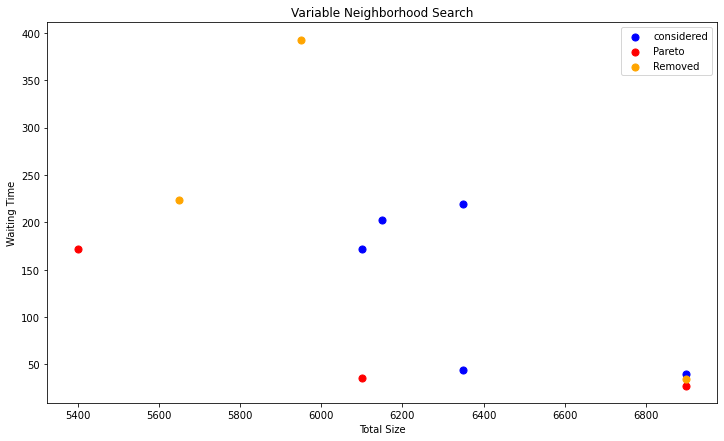

AttributeError: 'VNSMultiObj' object has no attribute 'print_pareto_frontier'

In [30]:
# init_sol.change_wt_obj("max")
# vns_multi = VNSMultiObj(rg_, init_sol, n_iteration, wt_obj='max')
# vns_multi.run()
# print("time taken for VNS :{0:.5f}s".format(vns_multi.time))
# vns_multi.plot()